1. This notebook demo how to build and run an AI agent that translates natural language queries into SQL queries to fetch transaction data from a PostgreSQL database.

2. If you want to run this notebook, make sure you have set up the environment variables in a `.env` file with variables stated in the `README.md` file.

3. How to Run:
    - First, you have to run section `1. Import libraries` first to import all the required libraries.
    - Then you can skip to section `5. Combine into an AI workflow` to see how the agent works.
    - Other sections are just to show how each component is built.

**1. Import libraries**

In [ ]:
# Import all the required libraries
import os
import re
from typing import List, Literal, Optional, TypedDict

from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from langgraph.graph import END, START, StateGraph
from psycopg import AsyncConnection, ProgrammingError
from pydantic import BaseModel, Field

load_dotenv()

True

In [ ]:
# Initialize the LLM with Azure OpenAI
# Remember to set these environment variables in your .env file first
llm = AzureChatOpenAI(
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    temperature=0,
    seed=42,
)

In [44]:
# Initialize the connection string for PostgreSQL
conn_string = (
    f"dbname={os.environ['POSTGRES_DB']} "
    f"user={os.environ['POSTGRES_USER']} "
    f"password={os.environ['POSTGRES_PASSWORD']} "
    f"host={os.environ['POSTGRES_SERVER']} "
    f"port={os.environ['POSTGRES_PORT']} "
)

**2. SQL translator node**

**2.1 Prompt template**
- I asked the LLM to act as an expert SQL agent so that it can generate more accurate parameterized SQL queries. The prompt also restricted the LLM to generate read-only access SQL queries prevent the LLM generate unsafe write operations like delete the the transactions table.

- I also included the table schema for the transactions table to provide the LLM with the available columns and their data types. This helps the LLM better understand the database structure and prevents it from hallucinating tables or columns that are not existed.

- In the instructions section, I applied a Chain-of-Thought prompting techniques by asking the LLM to first reason about whether the user query can be answered with the given table schema, then identify the operations and finally generate a parameterized SQL query. This reasoning process reduces errors and improves the reliability of the generated parameterized SQL queries.

- I also defined several edge cases to guide the LLM’s behavior in situations when to not generate parameterized SQL query. For example, it should reject write operations, clarify ambiguous user queries, deny access to other people's data and state clearly when a requested column or table is not available in the schema. This ensure that the LLM responds safely in unexpected scenarios.

- I added a fallback mechanism for the sql executor node (which will be explained in the following section) by passing the last SQL execution error message back into the prompt. This allows the LLM to correct its previously generated parameterized SQL query.

- Something could be improved in future is that let the LLM to load only the relavant table schemas rather than including all the table schemas. Passing all the tables into the prompt template can increase the context length, increase the API costs and make the prompt template more complex.

In [3]:
sql_translator_template = """
    [ROLE]
    You are an expert SQL agent. You will be given a user query in natural language from [USER].
    Your goal is to translate the user query into a parameterized SQL query for read-only access.

    [TABLE SCHEMA]
    CREATE TABLE transactions (
        clnt_id INTEGER,
        bank_id INTEGER,
        acc_id INTEGER,
        txn_id TEXT,
        txn_date TIMESTAMP,
        description TEXT,
        amt NUMERIC(14,2),
        cat VARCHAR(100),
        merchant VARCHAR(255)
    );
    
    [INSTRUCTIONS]
    1. You must ONLY use the tables/columns that are present in [TABLE SCHEMA].
    2. You must ensure that the [USER] can ONLY access their own data. 
    3. Think before you translate the [USER QUERY] into parameterized SQL query.
        a. First, identify whether the [USER QUERY] can be answered using the provided [TABLE SCHEMA].
        b. If the [USER QUERY] can be answered using the provided [TABLE SCHEMA], identify the operations needed to answer the [USER QUERY].
        c. Then, generate a parameterized SQL query using the identified operations and the tables/columns from the [TABLE SCHEMA].
        d. Finally, evaluate the generated parameterized SQL query to ensure it is correct and safe.
    4. ONLY return a parameterized SQL query and the params if [USER QUERY] can be answered.
    
    [EDGE CASES]
    - If the [USER] tries to modify or delete data, respond with "Write operations not allowed."
    - If [USER QUERY] is ambiguous, respond with "Please clarify your query."
    - If [USER] tries to access data for another user ([USER QUERY] consists of different client id), respond with "You may only access your own data."
    - If [USER] asks about tables/columns not present in [TABLE SCHEMA], respond with "I cannot answer based on the provided table schemas."
    - If [ERROR MESSAGE] is present meaning the previous generated parameterized SQL query failed to execute, you MUST correct the parameterized SQL query based on the context of [ERROR MESSAGE].

    [USER]
    {client_id}

    [USER QUERY]
    {query}
    
    [ERROR MESSAGE]
    {error_message}
""".strip()

In [4]:
# Define the prompt template for SQL translator
sql_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", sql_translator_template),
        ("user", "{query}"),
    ]
)

**2.2 Structured output schema**

In [5]:
class Param(BaseModel):
    """Param schema for binding in parameterized SQL query."""

    name: str = Field(description="Parameter name to bind in SQL query")
    value: str = Field(description="Parameter value as string")


class SQLTranslator(BaseModel):
    """Response schema for translating user query into parameterized SQL query."""

    sql_query: Optional[str] = Field(
        description="Parameterized SQL query with placeholders."
    )
    params: Optional[List[Param]] = Field(
        description="List of parameters to bind to the query.",
        default_factory=list,
    )
    error_message: Optional[str] = Field(
        None, description="Message to the user if the query cannot be answered."
    )

In [6]:
# Wrap the LLM with structured output and the SQLTranslator schema
# So that the LLM will generate output by following the SQLTranslator schema
structured_llm = llm.with_structured_output(SQLTranslator)

In [7]:
query = "How much did I spend in 2023?"

**2.3 LLM invocation**

In [8]:
# Invoke the structured LLM with the SQL prompt
sql_response = await structured_llm.ainvoke(
    sql_prompt.invoke({"client_id": 1, "query": query, "error_message": None})
)

In [9]:
# We can see the output generated by the LLM is following the SQLTranslator schema
# This makes it easy to get the structured data we need
print(sql_response.sql_query)
print(sql_response.params)
print(sql_response.error_message)

SELECT SUM(amt) AS total_spent FROM transactions WHERE clnt_id = ? AND txn_date >= ? AND txn_date < ?;
[Param(name='clnt_id', value='1'), Param(name='start_date', value='2023-01-01'), Param(name='end_date', value='2024-01-01')]
None


**3. SQL exector node**
- I have created "transactions" table  and imported data from "data.csv" into PostgreSQL

In [12]:
# I have to replace the parameter placeholders in the generated parameterized SQL query
# This is because the LLM may generate different types of placeholders like "?", ":param"
# Since this can be solved in code, I will do it here instead of asking the LLM to do it.
# So that it won't confuse the LLM with too many instructions.
sql_query = sql_response.sql_query.replace("?", "%s")
sql_query = re.sub(r":\w+", "%s", sql_query)
values = [param.value for param in sql_response.params] if sql_response.params else []

**3.1 Fetch data from db**

In [13]:
try:
    async with await AsyncConnection.connect(conn_string) as conn:
        async with conn.cursor() as cur:
            await cur.execute(sql_query, values)
            rows = await cur.fetchall()
            print(rows)

            # Get column names which is needed to create dict in next step
            columns = [desc[0] for desc in cur.description]
            print(columns)

            # Convert from list of tuples to list of dicts
            # So that the LLM can easily understand which value belongs to which column
            result = [dict(zip(columns, row)) for row in rows]
            print(result)
except ProgrammingError as e:
    # This exception will be caught if the generated parameterized SQL query fails to execute
    # For example, if the parameterized SQL query's syntax is incorrect or parameters are missing
    # I will explain the implementation of the fallback mechanism in the section where I combine everything into an AI workflow
    print(f"SQL Execution Error: {str(e)}")

[(Decimal('85.00'),)]
['total_spent']
[{'total_spent': Decimal('85.00')}]


**4. Generator node**

**4.1 Prompt Template**
- This is the prompt template for generating response based on the SQL query result and user query.

- I gave the LLM a role as an ethical AI assistant to ensure it responds safely.

- I also asked the LLM to address the user directly using "you" or "your" because it looks more natural and human like. Not only that, I asked LLM to avoid avoid using phrases like "Based on the provided context" to make the response more direct and clear.

- I asked the LLM to only generate response based on the provided context and user query to avoid hallucination.

In [ ]:
generator_template = """
    [ROLE]
    You are an ethical AI assistant that helps users by generating response based on the [CONTEXT] and [USER QUERY].
    You MUST always address the user directly using "you" or "your".
    
    [INSTRUCTIONS]
    1. ONLY generate a clear and direct response based on the [CONTEXT] and the [USER QUERY].
    2. Do NOT generate any information that is not present in the [CONTEXT].
    3. Do NOT use any phrases like "Based on the provided context" or other similar phrases.

    [CONTEXT]
    {context}
    
    [USER QUERY]
    {query}
""".strip()

In [ ]:
generator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", generator_template),
        ("user", "{query}"),
    ]
)

**4.2 Structured output schema**

In [18]:
class Generator(BaseModel):
    """Response schema for generating output based on context and user query."""

    response: str = Field(
        description="Generated response based on the context and user query."
    )

In [19]:
structured_llm = llm.with_structured_output(Generator)

**4.3 LLM invocation**

In [20]:
res = await structured_llm.ainvoke(
    generator_prompt.invoke({"context": rows, "query": query})
)
print(res.response)

You spent $85.00 in 2023.


**5. Combine into an AI workflow**

In [ ]:
# Dynamic chain builder function used to build different agents or node functions
def build_chain(prompt_template: str, schema: BaseModel):
    """Build a LLM chain with the given prompt template and schema for structured output.

    Args:
        prompt_template (str): The prompt template to use.
        schema (Type[BaseModel]): The Pydantic schema to use for structured output.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", prompt_template),
            ("user", "{query}"),
        ]
    )

    return prompt | llm.with_structured_output(schema)

**5.1 Prompt Templates**

In [22]:
def sql_translator_template() -> str:
    """Template for translating user query to parameterized SQL query.

    Returns:
        str: The SQL translation template with placeholders for dynamic content.
    """
    return """
        [ROLE]
        You are an expert SQL agent. You will be given a user query in natural language from [USER].
        Your goal is to translate the user query into a parameterized SQL query for read-only access.

        [TABLE SCHEMA]
        CREATE TABLE transactions (
            clnt_id INTEGER,
            bank_id INTEGER,
            acc_id INTEGER,
            txn_id TEXT,
            txn_date TIMESTAMP,
            description TEXT,
            amt NUMERIC(14,2),
            cat VARCHAR(100),
            merchant VARCHAR(255)
        );
        
        [INSTRUCTIONS]
        1. You must ONLY use the tables/columns that are present in [TABLE SCHEMA].
        2. You must ensure that the [USER] can ONLY access their own data. 
        3. Think before you translate the [USER QUERY] into parameterized SQL query.
            a. First, identify whether the [USER QUERY] can be answered using the provided [TABLE SCHEMA].
            b. If the [USER QUERY] can be answered using the provided [TABLE SCHEMA], identify the operations needed to answer the [USER QUERY].
            c. Then, generate a parameterized SQL query using the identified operations and the tables/columns from the [TABLE SCHEMA].
            d. Finally, evaluate the generated parameterized SQL query to ensure it is correct and safe.
        4. ONLY return a parameterized SQL query and the params if [USER QUERY] can be answered.
        
        [EDGE CASES]
        - If the [USER] tries to modify or delete data, respond with "Write operations not allowed."
        - If [USER QUERY] is ambiguous, respond with "Please clarify your query."
        - If [USER] tries to access data for another user ([USER QUERY] consists of different client id), respond with "You may only access your own data."
        - If [USER] asks about tables/columns not present in [TABLE SCHEMA], respond with "I cannot answer based on the provided table schemas."
        - If [ERROR MESSAGE] is present meaning the previous generated parameterized SQL query failed to execute, you MUST correct the parameterized SQL query based on the context of [ERROR MESSAGE].

        [USER]
        {client_id}

        [USER QUERY]
        {query}
        
        [ERROR MESSAGE]
        {error_message}
    """.strip()

In [ ]:
def generator_template() -> str:
    """Template for generating response based on the context and user query.

    Returns:
        str: The response generation template with placeholders for dynamic content.
    """
    return """
        [ROLE]
        You are an ethical AI assistant that helps users by generating response based on the [CONTEXT] and [USER QUERY].
        You MUST always address the user directly using "you" or "your".
        
        [INSTRUCTIONS]
        1. ONLY generate a clear and direct response based on the [CONTEXT] and the [USER QUERY].
        2. Do NOT generate any information that is not present in the [CONTEXT].
        3. Do NOT use any phrases like "Based on the provided context" or other similar phrases.

        [CONTEXT]
        {context}
        
        [USER QUERY]
        {query}
    """.strip()

**5.2 Structured output schema**

In [28]:
class Param(BaseModel):
    """Param schema for binding in parameterized SQL query."""

    name: str = Field(description="Parameter name to bind in SQL query")
    value: str = Field(description="Parameter value as string")


class SQLTranslator(BaseModel):
    """Response schema for translating user query into parameterized SQL query."""

    sql_query: Optional[str] = Field(
        description="Parameterized SQL query with placeholders."
    )
    params: Optional[List[Param]] = Field(
        description="List of parameters to bind to the query.",
        default_factory=list,
    )
    error_message: Optional[str] = Field(
        None, description="Message to the user if the query cannot be answered."
    )


class Generator(BaseModel):
    """Response schema for generating output based on context and user query."""

    response: str = Field(
        description="Generated response based on the context and user query."
    )

**5.3 State schema**
- Each state schema represents the data at different node function in the AI workflow
- This makes it easy to track and manage the data.

In [30]:
class InputState(TypedDict):
    """Represents the initial input state for processing a query."""

    client_id: int
    query: str


class ParamState(TypedDict):
    """Represents a parameter for a parameterized SQL query."""

    name: str
    value: str


class SQLTranslatorState(TypedDict):
    """Represents the state after translating a query into SQL."""

    query: str
    sql_query: Optional[str]
    params: Optional[List[ParamState]]
    error_message: Optional[str]
    fallback_count: Optional[int]


class SQLExecutorState(TypedDict):
    """Represents the state after executing a SQL query."""

    query: str
    result: Optional[List[dict]]
    error_message: Optional[str]
    fallback_count: Optional[int]


class OutputState(TypedDict):
    """Represents the final output state after processing the query."""

    response: str


class OverallState(InputState, SQLTranslatorState, SQLExecutorState, OutputState):
    """Represents the complete state throughout the query processing lifecycle."""

    pass

**5.4 Node Functions**
- There are total of three node functions which are "sql_translator", "sql_executor" and "generator".

In [59]:
async def sql_translator(state: InputState) -> SQLTranslatorState:
    """Translate the user query into a parameterized SQL query.

    Args:
        state (InputState): The input state containing the user id and user query.

    Returns:
        SQLTranslatorState: The SQL translator state containing the translated query and parameters.
    """
    try:
        formatted_prompt = build_chain(sql_translator_template(), SQLTranslator)
        response = await formatted_prompt.ainvoke(
            {
                "client_id": state["client_id"],
                "query": state["query"],
                "error_message": "",
            }
        )

        return {
            "query": state["query"],
            "sql_query": response.sql_query if response.sql_query else None,
            "params": (
                [
                    {"name": param.name, "value": param.value}
                    for param in response.params
                ]
                if response.params
                else None
            ),
            "error_message": (
                response.error_message if response.error_message else None
            ),
        }
    except Exception as e:
        raise Exception(f"Error in sql_translator: {str(e)}")

In [71]:
async def sql_executor(state: SQLTranslatorState) -> SQLExecutorState:
    """Execute the parameterized SQL query and return the results.

    Args:
        state (SQLTranslatorState): The SQL translator state containing the translated query and parameters.

    Returns:
        SQLExecutorState: The SQL executor state containing the query results.
    """
    try:
        if state["sql_query"] is None:
            return {
                "query": state["query"],
                "result": None,
                "error_message": state["error_message"] or "No SQL query to execute.",
            }

        sql_query = state["sql_query"].replace("?", "%s")
        sql_query = re.sub(r":\w+", "%s", sql_query)

        values = (
            [param["value"] for param in state["params"]] if state.get("params") else []
        )

        try:
            async with await AsyncConnection.connect(conn_string) as conn:
                async with conn.cursor() as cur:
                    await cur.execute(sql_query, values)
                    rows = await cur.fetchall()
                    columns = [desc[0] for desc in cur.description]
                    result = [dict(zip(columns, row)) for row in rows]

            return {
                "query": state["query"],
                "result": result,
                "error_message": None,
            }
        except ProgrammingError as e:
            # When SQL execution fails, it will pass the error message back to SQL translator node
            # Then the SQL translator node will anlayze the error message and generate a new parameterized SQL query
            # This fallback mechanism will retry up to 3 times.
            return {
                "query": state["query"],
                "result": None,
                "error_message": (
                    f"SQL Execution Error: {state['sql_query']} "
                    f"Params: {state.get('params')} "
                    f"Error: {str(e)}"
                ),
                "fallback_count": state.get("fallback_count", 0) + 1,
            }

    except Exception as e:
        raise Exception(f"Error in sql_executor: {str(e)}")

In [61]:
async def generator(state: SQLExecutorState) -> OutputState:
    """Generate human-readable response based on the SQL query results.

    Args:
        state (SQLExecutorState): The SQL executor state containing the query results.

    Returns:
        OutputState: The output state containing the response.
    """
    try:
        if state["error_message"] is not None:
            return {
                "response": state["error_message"],
            }

        formatted_prompt = build_chain(generator_template(), Generator)
        res = await formatted_prompt.ainvoke(
            {
                "context": state["result"] or "No data found.",
                "query": state["query"],
            }
        )

        return {"response": res.response}
    except Exception as e:
        raise Exception(f"Error in generator: {str(e)}")

In [ ]:
# This is the routing function to determine the next step after the SQL translator node finishes.
# The Literal type is used to restrict the return value to only "sql_executor" or "generator" 
# So that the graph can validate the routing function's return value.
def route_after_sql_translator(
    state: SQLTranslatorState,
) -> Literal["sql_executor", "generator"]:
    """Determine the next step after SQL translation.

    Args:
        state (SQLTranslatorState): The current state after SQL translation.

    Returns:
        Literal["sql_executor", "generator"]: The next step to take.
    """
    # If there is an error message, it means the parameterized SQL query cannot be generated.
    # So I will skip to the generator node to generate a response based on the error message without calling the LLM.
    if state.get("result") is not None:
        return "generator"

    # If the fallback count is less than 3, it means the previous generated parameterized SQL query failed to execute.
    # Then it will navigate to the SQL executor node to retry executing the new parameterized SQL query generated by the SQL translator node.
    if state.get("fallback_count", 0) <= 3:
        return "sql_executor"

    # If the fallback count is more than 3, it means the parameterized SQL query failed to execute 3 times.
    # Then I will skip to the generator node to generate a response based on the error message without calling the LLM.
    return "generator"

In [ ]:
# This is the routing function to determine the next step after the SQL executor node finishes.
def route_after_sql_executor(
    state: SQLExecutorState,
) -> Literal["sql_translator", "generator"]:
    """Determine the next step after SQL execution.

    Args:
        state (SQLExecutorState): The current state after SQL execution.

    Returns:
        Literal["sql_translator", "generator"]: The next step to take.
    """
    err = state.get("error_message") or ""

    # If there is an error message with "SQL Execution Error:", it means the parameterized SQL query failed to execute.
    # Then check the fallback count to decide whether to fallback to the SQL translator node to generate a new parameterized SQL query.
    if "SQL Execution Error:" in err and state.get("fallback_count", 0) < 3:
        return "sql_translator"

    # Navigate to the generator node to generate a response based on the executed parameterized SQL query results.
    return "generator"

In [ ]:
# This function builds the graph representing the agent workflow.
# It defines the node functions, connecting the node functions and return the compiled state graph.
def build_graph() -> StateGraph:
    """Build the graph representing the agent workflow.

    Returns:
        StateGraph: The compiled state graph representing the agent workflow.
    """
    graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
    graph.add_node("sql_translator", sql_translator)
    graph.add_node("sql_executor", sql_executor)
    graph.add_node("generator", generator)

    graph.add_edge(START, "sql_translator")
    graph.add_conditional_edges("sql_translator", route_after_sql_translator)
    graph.add_conditional_edges("sql_executor", route_after_sql_executor)
    graph.add_edge("generator", END)

    return graph.compile()

**5.5 Graph Visualization**

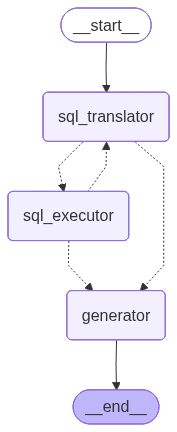

In [70]:
from IPython.display import Image, display

png_bytes = build_graph().get_graph(xray=1).draw_mermaid_png()
display(Image(data=png_bytes))

**5.6 Graph invocation**

In [72]:
await build_graph().ainvoke(
    {
        "client_id": 1,
        "query": "How much did I spend and what was the category in 2023?",
    }
)

{'response': "You spent $40.00 in the category 'Loans' and $45.00 in the category 'Transfer Credit' in 2023."}

In [73]:
await build_graph().ainvoke(
    {
        "client_id": 1,
        "query": "How much did I spend in 2023?",
    }
)

{'response': 'You spent a total of $85.00 in 2023.'}

In [74]:
await build_graph().ainvoke(
    {
        "client_id": 1,
        "query": "List other people's transactions",
    }
)

{'response': 'You may only access your own data.'}

In [75]:
await build_graph().ainvoke(
    {
        "client_id": 1,
        "query": "Show me all my transactions",
    }
)

{'response': 'Here are your transactions:\n\n1. **Date:** 2023-08-14, **Description:** ONLINE TRANSFER FROM NDonatas DanyalDA O CARSON BUSINESS CHECKING 1216 1216, **Amount:** $25.00, **Category:** Transfer Credit, **Merchant:** NA\n2. **Date:** 2023-06-02, **Description:** ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKING 1216 1216, **Amount:** $16.00, **Category:** Transfer Credit, **Merchant:** NA\n3. **Date:** 2023-06-01, **Description:** ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKING 1216 1216, **Amount:** $4.00, **Category:** Transfer Credit, **Merchant:** NA\n4. **Date:** 2023-09-29, **Description:** Earnin PAYMENT Donatas Danyal, **Amount:** $20.00, **Category:** Loans, **Merchant:** Earnin\n5. **Date:** 2023-09-25, **Description:** MONEY TRANSFER AUTHORIZED ON 09/25 FROM Earnin CDAEJ_B CA S583269001208168 111, **Amount:** $20.00, **Category:** Loans, **Merchant:** Earnin'}

In [76]:
await build_graph().ainvoke(
    {
        "client_id": 1,
        "query": "Delete all my transactions",
    }
)

{'response': 'Write operations not allowed.'}

In [77]:
await build_graph().ainvoke(
    {
        "client_id": 880,
        "query": "What is my balance?",
    }
)

{'response': 'Your balance is -2,469,656.22.'}

In [79]:
await build_graph().ainvoke(
    {
        "client_id": 2,
        "query": "Can you show me the categories of transactions?",
    }
)

{'response': 'The categories of transactions are: Check Deposit, Loans, Payroll, Restaurants, Third Party, Transfer Deposit, and Uncategorized.'}